In [1]:
import os
import torch
import numpy as np
from pprint import pprint
from dataclasses import dataclass, asdict
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

import torch.nn.functional as F

from conditional_rate_matching.models.generative_models.crm import CRM
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig

from conditional_rate_matching.models.metrics.crm_loglikelihood import calculate_batch_log_likelihood,rate_to_probabilities
from conditional_rate_matching.models.metrics.crm_loglikelihood import get_log_likelihood,get_log_likelihood_states_dataloader,calculate_batch_log_likelihood
from conditional_rate_matching.models.metrics.crm_loglikelihood import evaluate_rate_in_batches

from torch.distributions import Categorical,Dirichlet

from conditional_rate_matching.models.temporal_networks.temporal_networks_config import (
    TemporalMLPConfig,
    TemporalDeepMLPConfig
)

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from conditional_rate_matching.utils.plots.histogram_colors_plots import (
    get_conditional_histograms_paths,
    categorical_counts_per_path,
    plot_time_series_histograms
)

In [3]:
from conditional_rate_matching import results_path

# Functions

In [4]:
import os
import torch
import numpy as np
from dataclasses import dataclass, asdict
import torch.nn.functional as F
from conditional_rate_matching.models.generative_models.crm import CRM
from torch.distributions import Categorical

def rate_to_probabilities(rate_f,x_0,x_1,delta_t):
    """
    """
    # find who is equal
    batch_index_equal = torch.where(x_0 == x_1)[0]
    dimension_equal = torch.where(x_0 == x_1)[1]
    who_equal = x_0[torch.where(x_0 == x_1)].long()

    # set diagonal to one
    rate_f[batch_index_equal,dimension_equal,who_equal] = 0.
    rates_diagonal = rate_f.sum(axis=-1)
    rate_f[batch_index_equal,dimension_equal,who_equal] = -rates_diagonal[batch_index_equal,dimension_equal]

    #calculate probabilities
    rate_f = delta_t*rate_f
    rate_f[batch_index_equal,dimension_equal,who_equal] = 1. + rate_f[batch_index_equal,dimension_equal,who_equal]
    return rate_f 

def evaluate_rate_in_batches(crm,crm_b,x_path_b_0,x_path_b_1,time_b_0,time_f_1,batch_size=10,shapes=(32,10,2)):
    """
    """
    sample_size,number_of_time_steps,dimensions = shapes
    total_batches = (sample_size * (number_of_time_steps - 1) + batch_size - 1) // batch_size

    # Initialize empty lists to store batch results if necessary
    rates_b = []
    rates_f = []
    for batch_index in range(total_batches):
        start_idx = batch_index * batch_size
        end_idx = min((batch_index + 1) * batch_size, sample_size * (number_of_time_steps - 1))

        # Extracting batches for input to the neural network
        x_path_b_0_batch = x_path_b_0[start_idx:end_idx]
        x_path_b_1_batch = x_path_b_1[start_idx:end_idx]
        time_b_0_batch = time_b_0[start_idx:end_idx]
        time_f_1_batch = time_f_1[start_idx:end_idx]

        # Evaluating forward and backward rates for each batch
        rate_b_batch = crm_b.forward_rate(x_path_b_0_batch, time_b_0_batch)
        rate_f_batch = crm.forward_rate(x_path_b_1_batch, time_f_1_batch)

        # Storing the batch results if necessary for further processing
        rates_b.append(rate_b_batch)
        rates_f.append(rate_f_batch)
    
    # Concatenate all batch results into a single tensor
    rates_b = torch.cat(rates_b, dim=0)
    rates_f = torch.cat(rates_f, dim=0)

    return rates_b,rates_f

@torch.no_grad
def calculate_batch_log_likelihood(crm:CRM,crm_b:CRM,databatch1,delta_t=None,ignore_=1,in_batches=False,batch_size=100):
    """
    Parameters
    ----------
    crm: trained crm model in forward time
    crm_b: trained crm model in forward time
    databatch1: databacth to calculate likelihood with
    delta_t: None
    ignore_: steps to ignore of the process

    y0 corresponds to the variables indexing of the backward process

    q(y3|y2)q(y2|y1)q(y1|y0) q(y0) <- q is backward process 

    numerator    q(x0|x1)q(x1|x2)q(x2|x3)  q(x3)
    denominator  p(x1|x0)p(x2|x1)p(x3|x2)

    q(3) is sample from target of forward process

    y0 corresponds to x3 for the forward process y3 to x0

    returns
    -------
    x_0, log_likelihood_10: 
        (torch.Tensor) from backward process x_0
        (torch.Tensor) log_likelihood per batch (dimensions sum out)
    """
    x_1 = databatch1[0]
    batch_size = x_1.shape[0]

    # we simulate the path backwards
    x_f, x_path_b, t_path_b = crm_b.pipeline(return_path=True,x_0=x_1)
    sample_size, number_of_time_steps, dimensions = x_path_b.shape[0],x_path_b.shape[1],x_path_b.shape[2]
    t_path_b = t_path_b[None,:].repeat(batch_size,1)

    # reshape states and vectors of paths (one step ahead)
    # we calculate the inverted time (the backward process was also trained 0. to 1.)

    x_0 = x_path_b[:,-(ignore_+1),:] #noise is at the end of backward path

    x_path_b_0 = x_path_b[:,:-1,:] #before step in backward
    time_b_0 = t_path_b[:,:-1] #before time in backward

    x_path_b_1 = x_path_b[:,1:,:] #after step in backward
    time_f_1 = 1. - t_path_b[:,1:] #after time in backward

    x_path_b_0 = x_path_b_0.reshape(sample_size*(number_of_time_steps-1),dimensions)
    x_path_b_1 = x_path_b_1.reshape(sample_size*(number_of_time_steps-1),dimensions)
    time_b_0 = time_b_0.reshape(sample_size*(number_of_time_steps-1)) # reshape
    time_f_1 = time_f_1.reshape(sample_size*(number_of_time_steps-1)) # reshape

    if delta_t is None:
        delta_t = (t_path_b[:,1:] -  t_path_b[:,:-1])[0,3]

    # we evaluate forward and backward rate in backward process
    if in_batches:
        shapes = (sample_size,number_of_time_steps,dimensions)
        rate_b,rate_f = evaluate_rate_in_batches(crm,crm_b,x_path_b_0,x_path_b_1,time_b_0,time_f_1,
                                                 batch_size=batch_size,shapes=shapes)
    else:
        rate_b = crm_b.forward_rate(x_path_b_0,time_b_0)
        rate_f = crm.forward_rate(x_path_b_1,time_f_1)

    # we convert to probabilities based on the rule for the rates diagonal
    rate_f = rate_to_probabilities(rate_f,x_path_b_0,x_path_b_1,delta_t)
    rate_b = rate_to_probabilities(rate_b,x_path_b_0,x_path_b_1,delta_t)

    # we take the values of the rates evaluating at the correspondig next step
    rate_b = torch.gather(rate_b,2,x_path_b_1[:,:,None].long()).squeeze()
    rate_f = torch.gather(rate_f,2,x_path_b_0[:,:,None].long()).squeeze()

    # we write everything in the time dimensions
    rate_b = rate_b.reshape((batch_size,number_of_time_steps-1,dimensions))
    rate_f = rate_f.reshape((batch_size,number_of_time_steps-1,dimensions))
    
    # calculate log likelihood
    log_1_0 = torch.log(rate_b) - torch.log(rate_f)
    log_1_0[log_1_0.isnan()] = 0.
    if ignore_ > 0:
        log_1_0 = log_1_0[:, ignore_:-ignore_, :]
    else:
        log_1_0 = log_1_0[:, :, :]
    log_1_0 = log_1_0.sum(axis=1) # sum over time
    log_1_0 = log_1_0.sum(axis=-1) # sum over dimensions

    return x_0,log_1_0

def get_log_likelihood(crm:CRM,crm_b:CRM,delta_t=None,ignore_=1,in_batches=False,debug=True):
    """
    """
    dimensions = crm.config.data0.dimensions
    vocab_size = crm.config.data0.vocab_size
    probabilities_0 = torch.ones((dimensions,vocab_size))/vocab_size
    x0_distribution = Categorical(probabilities_0)

    if debug:
        probabilities_1 = torch.tensor(crm.config.data1.bernoulli_probability).squeeze()
        x1_distribution = Categorical(probabilities_1)
    
    LOG = []
    if debug:
        LOG_REAL = []
    for databatch1 in crm.dataloader_1.test():#<----------------------
        x_0, log_10 = calculate_batch_log_likelihood(crm,crm_b,databatch1,delta_t=delta_t,ignore_=ignore_,in_batches=in_batches)
        log_0 = x0_distribution.log_prob(x_0).sum(axis=-1)
        if debug:
            x_1 = databatch1[0]
            log_1_real = x1_distribution.log_prob(x_1).sum(axis=-1)
        log_1 = log_10 - log_0
        LOG.extend(log_1.tolist())
        if debug:
            LOG_REAL.extend(log_1_real.tolist())
    LOG = np.asarray(LOG).mean()
    if debug:
        LOG_REAL = np.asarray(LOG_REAL).mean()
        return -LOG,LOG_REAL
    return -LOG

def get_log_likelihood_states_dataloader(crm:CRM):
    """
    Log probabilities of known categorical probabilities
    """
    probabilities_1 = torch.tensor(crm.config.data1.bernoulli_probability).squeeze()
    x1_distribution = Categorical(probabilities_1)
    sample_size = 0
    LOG = 0.
    for databatch1 in crm.dataloader_1.test():
        x1 = databatch1[0]
        log_1 = x1_distribution.log_prob(x1).sum(axis=-1)

        # average overall data set
        batch_size = x1.size(0)
        sample_size += batch_size
        LOG = log_1.sum()
    LOG = LOG/sample_size
    return LOG

# Calculate

In [24]:
experiment_path_forward = results_path / "prenzlauer_experiment" / "colors_log_likelihood" / "forward_1"
experiment_path_backward = results_path / "prenzlauer_experiment" / "colors_log_likelihood" / "backward_1"

In [25]:
crm = CRM(experiment_dir=experiment_path_forward)
crm_b = CRM(experiment_dir=experiment_path_backward)
dimensions = crm.config.data1.dimensions
vocab_size = crm.config.data1.vocab_size
crm_b.config.pipeline.number_of_steps = 100
crm_b.config.pipeline.number_of_steps = 100
crm_b.config.pipeline.time_epsilon = 0.
crm.config.pipeline.time_epsilon = 0.
crm.config.pipeline.set_diagonal = True
crm_b.config.pipeline.set_diagonal = True

In [26]:
databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]
databatch0 = next(crm.dataloader_0.train().__iter__())
x_0 = databatch1[0]

In [27]:
get_log_likelihood(crm_b,crm,ignore_=0,in_batches=True)

100it [00:00, 662.10it/s]
100it [00:00, 921.10it/s]
100it [00:00, 935.84it/s]
100it [00:00, 889.22it/s]
100it [00:00, 867.14it/s]
100it [00:00, 750.63it/s]
100it [00:00, 817.98it/s]
100it [00:00, 833.15it/s]
100it [00:00, 937.87it/s]


(-19.08574357807636, -2.774543437957764)

In [28]:
x_f, x_path, t_path = crm.pipeline(sample_size=100,return_path=True)
x_f, x_path_b, t_path_b = crm_b.pipeline(sample_size=100,return_path=True)

100it [00:00, 730.49it/s]
100it [00:00, 841.47it/s]


In [29]:
generative_histogram = categorical_counts_per_path(x_path,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
generative_histogram_b = categorical_counts_per_path(x_path_b,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_path)

In [16]:
dimensions = crm.config.data0.dimensions
vocab_size = crm.config.data0.vocab_size
probabilities_0 = torch.ones((dimensions,vocab_size))/vocab_size
x0_distribution = Categorical(probabilities_0)

probabilities_1 = torch.tensor(crm.config.data1.bernoulli_probability).squeeze()
x1_distribution = Categorical(generative_histogram[-1])
log_0 = x0_distribution.log_prob(x_0).sum(axis=-1)

In [17]:
log_av= torch.zeros(databatch1[0].shape[0])
for i in range(10):
    x_0, log_10 = calculate_batch_log_likelihood(crm,crm_b,databatch1,ignore_=0)
    log_0 = x0_distribution.log_prob(x_0).sum(axis=-1)
    log_10 = log_10 - log_0
    log_av += log_10

100it [00:00, 918.99it/s]
100it [00:00, 953.18it/s]
100it [00:00, 936.42it/s]
100it [00:00, 904.89it/s]
100it [00:00, 970.74it/s]
100it [00:00, 827.84it/s]
100it [00:00, 946.71it/s]
100it [00:00, 694.84it/s]
100it [00:00, 851.33it/s]
100it [00:00, 831.28it/s]


In [18]:
log_av/10

tensor([18.4211, 16.9221, 21.4188, 24.4192, 20.3305, 23.4256, 24.4164, 20.6790,
        16.0868, 22.7352, 21.0494, 19.9957, 18.9502, 23.3667, 20.5135, 23.2797,
        19.2051, 20.3121, 21.1303, 21.3201, 20.0143, 17.4628, 22.3828])

In [19]:
x1_distribution.log_prob(databatch1[0]).sum(axis=1)

tensor([-2.7359, -2.2371, -2.7359, -1.5634, -2.0621, -2.0621, -1.5634, -1.5634,
        -2.7359, -2.2563, -2.7359, -2.0621, -2.0621, -1.7576, -2.2371, -1.5634,
        -2.0621, -2.7359, -1.5634, -2.2563, -1.7576, -2.0621, -1.5634])

# Plot paths for sanity check

In [20]:
x_f, x_path, t_path = crm.pipeline(sample_size=1000,return_path=True)
x_f, x_path_b, t_path_b = crm_b.pipeline(sample_size=1000,return_path=True)

100it [00:00, 645.58it/s]
100it [00:00, 735.59it/s]
100it [00:00, 805.94it/s]
100it [00:00, 662.06it/s]
100it [00:00, 616.20it/s]
100it [00:00, 670.45it/s]
100it [00:00, 744.46it/s]
100it [00:00, 796.54it/s]
100it [00:00, 744.02it/s]
100it [00:00, 830.18it/s]
100it [00:00, 816.23it/s]
100it [00:00, 693.98it/s]
100it [00:00, 537.15it/s]
100it [00:00, 856.22it/s]


In [21]:
generative_histogram = categorical_counts_per_path(x_path,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
generative_histogram_b = categorical_counts_per_path(x_path_b,dimensions=dimensions,vocab_size=vocab_size,normalize=True)
conditional_histograms_paths = get_conditional_histograms_paths(crm,t_path)

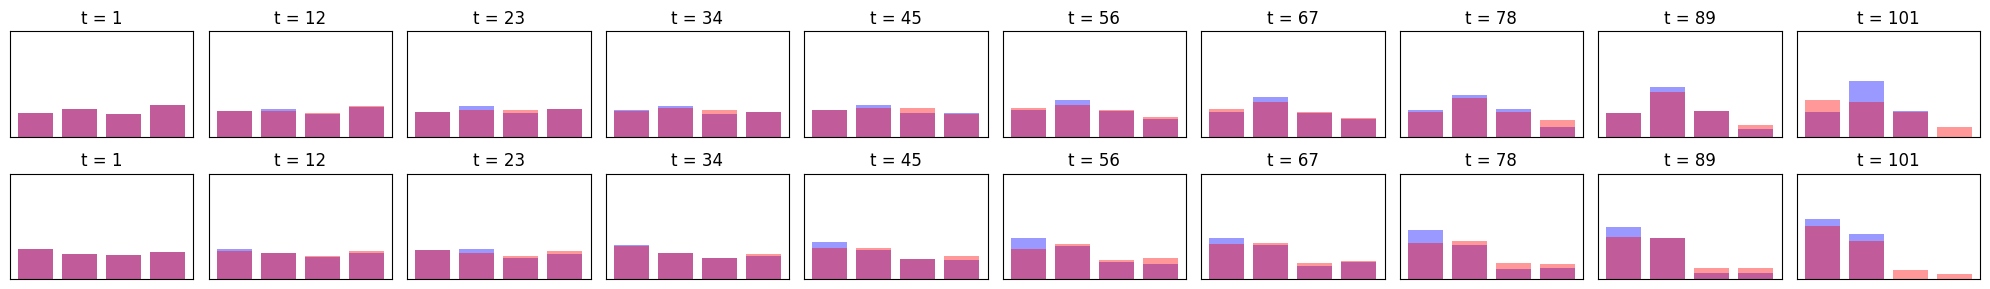

array([  0,  11,  22,  33,  44,  55,  66,  77,  88, 100])

In [22]:
plot_time_series_histograms(conditional_histograms_paths,generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

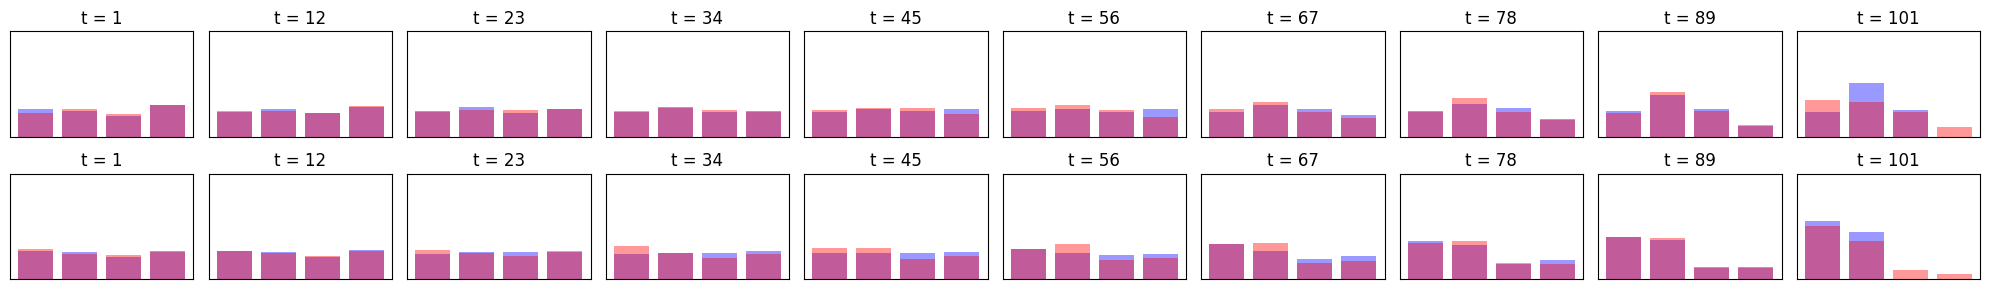

array([  0,  11,  22,  33,  44,  55,  66,  77,  88, 100])

In [23]:
plot_time_series_histograms(torch.flip(generative_histogram_b,dims=[0]),generative_histogram,num_timesteps_to_plot=10,figsize_tuple=(20, 3),plot_path=None)

# Memory friendly

In [ ]:
@torch.no_grad
def calculate_batch_log_likelihood(crm:CRM,crm_b:CRM,databatch1,delta_t=None,ignore_=1,in_batches=False,batch_size=100):
    """
    Parameters
    ----------
    crm: trained crm model in forward time
    crm_b: trained crm model in forward time
    databatch1: databacth to calculate likelihood with
    delta_t: None
    ignore_: steps to ignore of the process

    y0 corresponds to the variables indexing of the backward process

    q(y3|y2)q(y2|y1)q(y1|y0) q(y0) <- q is backward process 

    numerator    q(x0|x1)q(x1|x2)q(x2|x3)  q(x3)
    denominator  p(x1|x0)p(x2|x1)p(x3|x2)

    q(3) is sample from target of forward process

    y0 corresponds to x3 for the forward process y3 to x0

    returns
    -------
    x_0, log_likelihood_10: 
        (torch.Tensor) from backward process x_0
        (torch.Tensor) log_likelihood per batch (dimensions sum out)
    """
    x_1 = databatch1[0]
    batch_size = x_1.shape[0]

    # we simulate the path backwards
    x_f, x_path_b, t_path_b = crm_b.pipeline(return_path=True,x_0=x_1)
    sample_size, number_of_time_steps, dimensions = x_path_b.shape[0],x_path_b.shape[1],x_path_b.shape[2]
    t_path_b = t_path_b[None,:].repeat(batch_size,1)

    # reshape states and vectors of paths (one step ahead)
    # we calculate the inverted time (the backward process was also trained 0. to 1.)
    x_0 = x_path_b[:,-(ignore_+1),:]
    x_path_b_0 = x_path_b[:,:-1,:]
    time_b_0 = t_path_b[:,:-1] 

    x_path_b_1 = x_path_b[:,1:,:]
    time_f_1 = 1. - t_path_b[:,1:]

    x_path_b_0 = x_path_b_0.reshape(sample_size*(number_of_time_steps-1),dimensions)
    x_path_b_1 = x_path_b_1.reshape(sample_size*(number_of_time_steps-1),dimensions)
    time_b_0 = time_b_0.reshape(sample_size*(number_of_time_steps-1)) # reshape
    time_f_1 = time_f_1.reshape(sample_size*(number_of_time_steps-1)) # reshape

    if delta_t is None:
        delta_t = (t_path_b[:,1:] -  t_path_b[:,:-1])[0,3]

    # we evaluate forward and backward rate in backward process
    if in_batches:
        shapes = (sample_size,number_of_time_steps,dimensions)
        rate_b,rate_f = evaluate_rate_in_batches(crm,crm_b,x_path_b_0,x_path_b_1,time_b_0,time_f_1,
                                                 batch_size=batch_size,shapes=shapes)
    else:
        rate_b = crm_b.forward_rate(x_path_b_0,time_b_0)
        rate_f = crm.forward_rate(x_path_b_1,time_f_1)

    # we convert to probabilities based on the rule for the rates diagonal
    rate_f = rate_to_probabilities(rate_f,x_path_b_0,x_path_b_1,delta_t)
    rate_b = rate_to_probabilities(rate_b,x_path_b_0,x_path_b_1,delta_t)

    # we take the values of the rates evaluating at the correspondig next step
    rate_b = torch.gather(rate_b,2,x_path_b_1[:,:,None].long()).squeeze()
    rate_f = torch.gather(rate_f,2,x_path_b_0[:,:,None].long()).squeeze()

    # we write everything in the time dimensions
    rate_b = rate_b.reshape((batch_size,number_of_time_steps-1,dimensions))
    rate_f = rate_f.reshape((batch_size,number_of_time_steps-1,dimensions))
    
    # calculate log likelihood
    log_1_0 = torch.log(rate_b) - torch.log(rate_f)
    log_1_0 = log_1_0[:,ignore_:-ignore_,:]
    log_1_0 = log_1_0.sum(axis=1) # sum over time
    log_1_0 = log_1_0.sum(axis=-1) # sum over dimensions

    return x_0,log_1_0

In [11]:
NMC = 10
ignore_ = 0
in_batches = True

databatch1 = next(crm.dataloader_1.train().__iter__())
x_1 = databatch1[0]
batch_size = x_1.shape[0]

In [21]:
batch_size = x_1.shape[0]
#x_1.repeat((NMC,1))

In [137]:
# we simulate the path backwards
x_f, x_path_b, t_path_b = crm_b.pipeline(return_path=True,x_0=x_1)
sample_size, number_of_time_steps, dimensions = x_path_b.shape[0],x_path_b.shape[1],x_path_b.shape[2]
t_path_b = t_path_b[None,:].repeat(batch_size,1)

100it [00:00, 940.08it/s]


In [68]:
# reshape states and vectors of paths (one step ahead)
# we calculate the inverted time (the backward process was also trained 0. to 1.)
x_0 = x_path_b[:,-(ignore_+1),:]
x_path_b_0 = x_path_b[:,:-1,:]
time_b_0 = t_path_b[:,:-1] 

x_path_b_1 = x_path_b[:,1:,:]
time_f_1 = 1. - t_path_b[:,1:]

x_path_b_0 = x_path_b_0.reshape(sample_size*(number_of_time_steps-1),dimensions)
x_path_b_1 = x_path_b_1.reshape(sample_size*(number_of_time_steps-1),dimensions)
time_b_0 = time_b_0.reshape(sample_size*(number_of_time_steps-1)) # reshape
time_f_1 = time_f_1.reshape(sample_size*(number_of_time_steps-1)) # reshape


In [69]:
delta_t = None
if delta_t is None:
    delta_t = (t_path_b[0,1:] -  t_path_b[0,:-1])[3]

# we evaluate forward and backward rate in backward process
if in_batches:
    shapes = (sample_size,number_of_time_steps,dimensions)
    rate_b,rate_f = evaluate_rate_in_batches(crm,crm_b,x_path_b_0,x_path_b_1,time_b_0,time_f_1,
                                                batch_size=batch_size,shapes=shapes)
else:
    rate_b = crm_b.forward_rate(x_path_b_0,time_b_0)
    rate_f = crm.forward_rate(x_path_b_1,time_f_1)

In [70]:
delta_t

tensor(0.0009)

In [74]:
def rate_to_probabilities(rate_f,x_0,x_1,delta_t):
    """
    """
    # find who is equal
    batch_index_equal = torch.where(x_0 == x_1)[0]
    dimension_equal = torch.where(x_0 == x_1)[1]
    who_equal = x_0[torch.where(x_0 == x_1)].long()

    # set diagonal to one
    rate_f[batch_index_equal,dimension_equal,who_equal] = 0.
    rates_diagonal = rate_f.sum(axis=-1)
    rate_f[batch_index_equal,dimension_equal,who_equal] = -rates_diagonal[batch_index_equal,dimension_equal]

    #calculate probabilities
    rate_f = delta_t*rate_f
    rate_f[batch_index_equal,dimension_equal,who_equal] = 1. + rate_f[batch_index_equal,dimension_equal,who_equal]
    return rate_f 

In [75]:

# we convert to probabilities based on the rule for the rates diagonal
rate_f = rate_to_probabilities(rate_f,x_path_b_0,x_path_b_1,delta_t)
rate_b = rate_to_probabilities(rate_b,x_path_b_0,x_path_b_1,delta_t)



In [76]:
# we take the values of the rates evaluating at the correspondig next step
rate_b = torch.gather(rate_b,2,x_path_b_1[:,:,None].long()).squeeze()
rate_f = torch.gather(rate_f,2,x_path_b_0[:,:,None].long()).squeeze()


In [77]:
# we write everything in the time dimensions
rate_b = rate_b.reshape((batch_size,number_of_time_steps-1,dimensions))
rate_f = rate_f.reshape((batch_size,number_of_time_steps-1,dimensions))


In [78]:
rate_b.min()

tensor(0.0011, grad_fn=<MinBackward1>)

In [140]:
ignore_ = 1


# calculate log likelihood
log_1_0 = torch.log(rate_b) - torch.log(rate_f)
where_is_nan = torch.isnan(log_1_0)
log_1_0[where_is_nan] = 0.

In [141]:

log_1_0 = log_1_0[:,1:-1,:]
log_1_0 = log_1_0.sum(axis=1) # sum over time
log_1_0 = log_1_0.sum(axis=-1) # sum over dimensions
log_1_0

tensor([12.2998,  3.4075,  7.1999, 13.4026, 17.2627,  4.9115, 13.4395,  6.1670,
        15.8743, 19.0508,  6.8823, 15.4443,  8.8836, 13.9402,  9.5731,  9.8809,
        17.1612, 12.3343, 10.4748, 11.7813,  6.3161, 11.7294, 11.7541],
       grad_fn=<SumBackward1>)

In [124]:
crm.config.data1.bernoulli_probability

[[0.22952337563037872,
  0.5267442464828491,
  0.24344582855701447,
  0.000286526745185256],
 [0.5485062599182129,
  0.44988977909088135,
  9.73582928054384e-07,
  0.0016030115075409412]]

In [16]:
probabilities_1 = torch.tensor(crm.config.data1.bernoulli_probability).squeeze()
x1_distribution = Categorical(probabilities_1)
batch_size = x_1.shape[0]

In [17]:
x1_distribution.log_prob(x_1).sum(axis=-1)

tensor([-2.2116, -2.0723, -1.2416, -2.2116, -1.2416, -1.2416, -1.2416, -2.0723,
        -1.2416, -1.2416, -2.2116, -2.0723, -2.2116, -2.2705, -2.0723, -2.0134,
        -1.4398, -1.4398, -2.2705, -2.2116, -2.0723, -1.2416, -2.2116])